In [101]:
# Import stuff
import os
import scipy
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import theano

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

In [2]:
this_dat = np.load('taste_data.npy')
print(this_dat.shape)
# Trial x Nrn x Time

(30, 10, 7000)


In [212]:
# Convert spikes to counts by binning
time_lims = [2000,4000]
bin_width = 10
t_vec = np.arange(this_dat.shape[-1])
binned_t_vec = np.mean(t_vec[time_lims[0]:time_lims[1]].reshape((-1,bin_width)),axis=-1)
this_dat_binned = np.sum(this_dat[...,time_lims[0]:time_lims[1]].reshape(*this_dat.shape[:2],-1,bin_width),axis=-1)
this_dat_binned = np.vectorize(np.int)(this_dat_binned)

(10, 200)


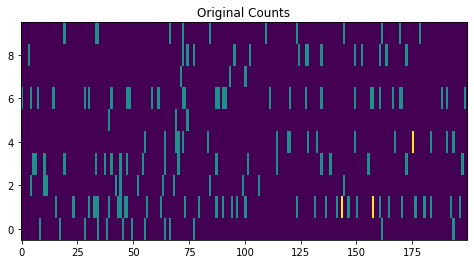

In [213]:
# Pick single trial
trial = 0
count_data = this_dat_binned[trial]
#count_data = np.sum(this_dat_binned,axis=0)
n_count_data = count_data.shape[-1]

plt.figure(figsize=(8,4))
plt.imshow((count_data>0)*1 + (count_data>1), interpolation = 'nearest', aspect = 'auto', origin = 'lower')
plt.title('Original Counts')

count_data = count_data>0
print(count_data.shape)
# Nrn X Time_bin

In [214]:
states = 2
split_list = np.array_split(count_data,states,axis=-1)
# Cut all to the same size
min_val = min([x.shape[-1] for x in split_list])
split_array = np.array([x[...,:min_val] for x in split_list])
print(split_array.shape)
mean_vals = np.mean(split_array,axis=-1)
mean_vals += 0.01 # To avoid zero starting prob
print(mean_vals)

(2, 10, 100)
[[0.12 0.2  0.11 0.14 0.07 0.04 0.18 0.03 0.06 0.07]
 [0.03 0.18 0.03 0.08 0.12 0.01 0.15 0.02 0.11 0.07]]


In [215]:
idx = np.arange(n_count_data) # Index
idx_range = idx.max() - idx.min()
print(idx.min())
print(idx.max())

0
199


In [216]:

lambda_names = ['lambda_{}'.format(i+1) for i in range(states)]
with pm.Model() as model:
    
    # Defining variables with priors
    #alpha = 1.0/count_data.mean(axis=-1)
    
    # Exponential prior on Poisson rate variable: for every state, for every neuron
    #lambda_1 = pm.Exponential("lambda_1", alpha, testval = mean_vals[0], shape = (count_data.shape[0]))
    #lambda_2 = pm.Exponential("lambda_2", alpha, testval = mean_vals[1], shape = (count_data.shape[0]))
    #lambda_3 = pm.Exponential("lambda_3", alpha, testval = mean_vals[1], shape = (count_data.shape[0]))
    
    # Finite, but somewhere on the lower end, Beta prior
    a_lambda = pm.HalfNormal('a_lambda', 2.)
    b_lambda = pm.HalfNormal('b_lambda', 5.)
    
    lambda_latent = pm.math.stack(
                        [pm.Beta(lambda_names[i], a_lambda, b_lambda, testval = mean_vals[i], 
                                   shape = (count_data.shape[0])) \
                         for i in range(states)]
    )
    
print(lambda_latent.tag.test_value.shape)
print(lambda_latent.tag.test_value)

(2, 10)
[[0.12 0.2  0.11 0.14 0.07 0.04 0.18 0.03 0.06 0.07]
 [0.03 0.18 0.03 0.08 0.12 0.01 0.15 0.02 0.11 0.07]]


In [217]:
even_switches = np.linspace(0,idx.max(),states+1)
even_switches_normal = even_switches/np.max(even_switches)
print(even_switches)
print(even_switches_normal[1:(states)])

[  0.   99.5 199. ]
[0.5]


In [218]:

with model:
    
    #tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)
    
    # Scaled beta mixture "somewhere in the middle" prior
    #a1 = pm.HalfNormal('a_tau1', 3.)
    #b1 = pm.HalfNormal('b_tau1', 6.)
    #a2 = pm.HalfNormal('a_tau2', 3.)
    #b2 = pm.HalfNormal('b_tau2', 3.)
    #tau_latent1 = pm.Beta('tau_latent1', a1, b1)
    #tau_latent2 = pm.Beta('tau_latent2', a2, b2)
    #tau_1 = pm.Deterministic('tau_1', idx.min() + (idx.max() - idx.min()) * tau_latent1)
    #tau_2 = pm.Deterministic('tau_2', tau_1 + (idx.max() - idx.min()) * tau_latent2)
    #tau = pm.math.stack(tau_1,tau_2)
    
    a = pm.HalfNormal('a_tau', 3.)
    b = pm.HalfNormal('b_tau', 3.)
    
    # Define transforms
    Order = pm.transforms.Ordered() # The usual one that pymc3 automatically applies to bounded variables
    Logodd = pm.transforms.LogOdds() # So that one changepoint is always ahead of the other
    chain_tran = pm.transforms.Chain([Logodd, Order])
    if states > 2:
        tau_latent = pm.Beta('tau_latent', a, b,
                              shape = states-1, transform = chain_tran, testval = even_switches_normal[1:states])
    else:
        tau_latent = pm.Beta('tau_latent', a, b, testval = even_switches_normal[1])   
        
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    #tau = pm.DiscreteUniform('tau',lower = idx.min(),upper = idx.max(),
    #                         shape = states-1, transform = pm.transforms.Ordered())
    
    # Dirichlet distribution gives state lenghts
    #tau_latent = pm.Dirichlet('tau_latent', np.ones(states))[:3]
    # State lengths converted to switchpoint times
    #tau = pm.Deterministic('tau', idx_range * tt.extra_ops.cumsum(tau_latent)) # Gives end times of states
    
    
#print(tau_latent.tag.test_value)
print(tau.tag.test_value)
    


99.5


In [219]:
model.basic_RVs

[a_lambda_log__,
 b_lambda_log__,
 lambda_1_logodds__,
 lambda_2_logodds__,
 a_tau_log__,
 b_tau_log__,
 tau_latent_logodds__]

(10, 200)


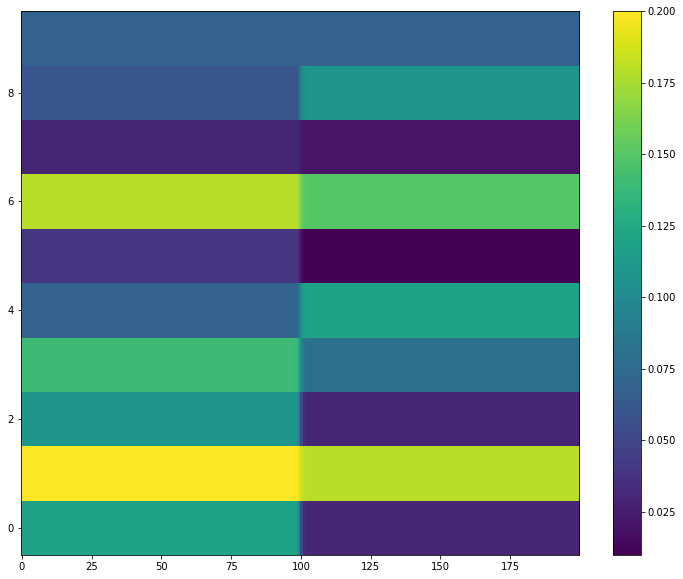

In [221]:
with model:
    
    # Assign lambdas to time_bin indices using sigmoids centered on switchpoints
    # Refer to https://www.desmos.com/calculator/yisbydv2cq
    
    #weight_0 = tt.nnet.sigmoid(2 * (idx - 0))
    
    weight_1 = tt.nnet.sigmoid(2 * (idx - tau)) # First state ends at tau[0]
    #weight_2 = tt.nnet.sigmoid(2 * (idx - tau[1])) # Second state ends at tau[1]
    #weight_3 = tt.nnet.sigmoid(2 * (idx - tau[2])) # Third state ends at tau[2]
    #weight_4 = tt.nnet.sigmoid(2 * (idx - tau[3])) # Fourth state ends at tau[3]
    #weight_5 = tt.nnet.sigmoid(2 * (idx - tau[4])) # Fourth state ends at tau[3]
    #weight_list = [tt.nnet.sigmoid(2 * (idx - tau[i])) for i in range(len(tau))]
    #weight_list = [tt.nnet.sigmoid(2 * (idx - 0)))] + weight_list
    
    #test = tt.as_tensor_variable(pm.math.stack([
    #                        1 - weight_1,
    #                        weight_1 * (1 - weight_2),
    #                        weight_2]))
    #print(test.tag.test_value.shape)
    #print(test.value)
    
    #test2 = np.matmul(test.T, lambda_latent)
    
    #lambda_ = pm.math.stack(
    #        [ ((1 - weight_1) * lambda_latent[0][i]) + \
    #          (weight_1 * lambda_latent[1][i])
    #         for i in range(count_data.shape[0])]
    #                )
    
    #lambda_ = pm.math.stack(
    #            [ ((1 - weight_1) * lambda_latent[0][i]) + \
    #              (weight_1 * (1 - weight_2) * lambda_latent[1][i]) + \
    #              (weight_2 * lambda_latent[2][i])
    #             for i in range(count_data.shape[0])]
    #                    )
    
    lambda_ = pm.math.stack(
            [ (1 - weight_1) * lambda_latent[0][i] + \
              (weight_1  * lambda_latent[1][i]) #+ \
              #(weight_2 * (1 - weight_3) * lambda_latent[2][i]) + \
              #(weight_3 * (1 - weight_4) * lambda_latent[3][i]) + \
              #(weight_4 * (1 - weight_5) * lambda_latent[4][i]) + \
              #weight_5  * lambda_latent[5][i]
             for i in range(count_data.shape[0])]
                    )
    
    #weight_vec = pm.math.stack([1 - weight_1,
    #                            weight_1 * (1 - weight_2),
    #                            weight_3])
    #print(weight_vec.T.tag.test_value.shape)
    #print(lambda_latent.T.tag.test_value.shape)
    #lambda_ = pm.math.stack(
    #                    theano.scan(fn = lambda nrn : weight_vec.T*nrn, sequences = [lambda_latent.T]))
    #lambda_ = pm.math.stack(pm.math.dot(weight_vec.T, lambda_latent[:,0]))
    

    
print(lambda_.tag.test_value.shape)
plt.imshow(lambda_.tag.test_value, aspect='auto',origin='lower');plt.colorbar();

In [222]:
# Using Bernoullo likelihood for count data
with model:
    observation = pm.Bernoulli("obs", lambda_, observed=count_data)
    

In [223]:
with model:
    trace = pm.sample(5000, tune=2500, chains = 8, cores = 8, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [tau_latent, b_tau, a_tau, lambda_2, lambda_1, b_lambda, a_lambda]
Sampling 8 chains, 17 divergences: 100%|██████████| 60000/60000 [03:05<00:00, 323.72draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.798253382156729, but should be close to 0.9. Try to increase the number of tuning steps.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9608564221195894, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7667748106978777, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9814810422169497, but should be c

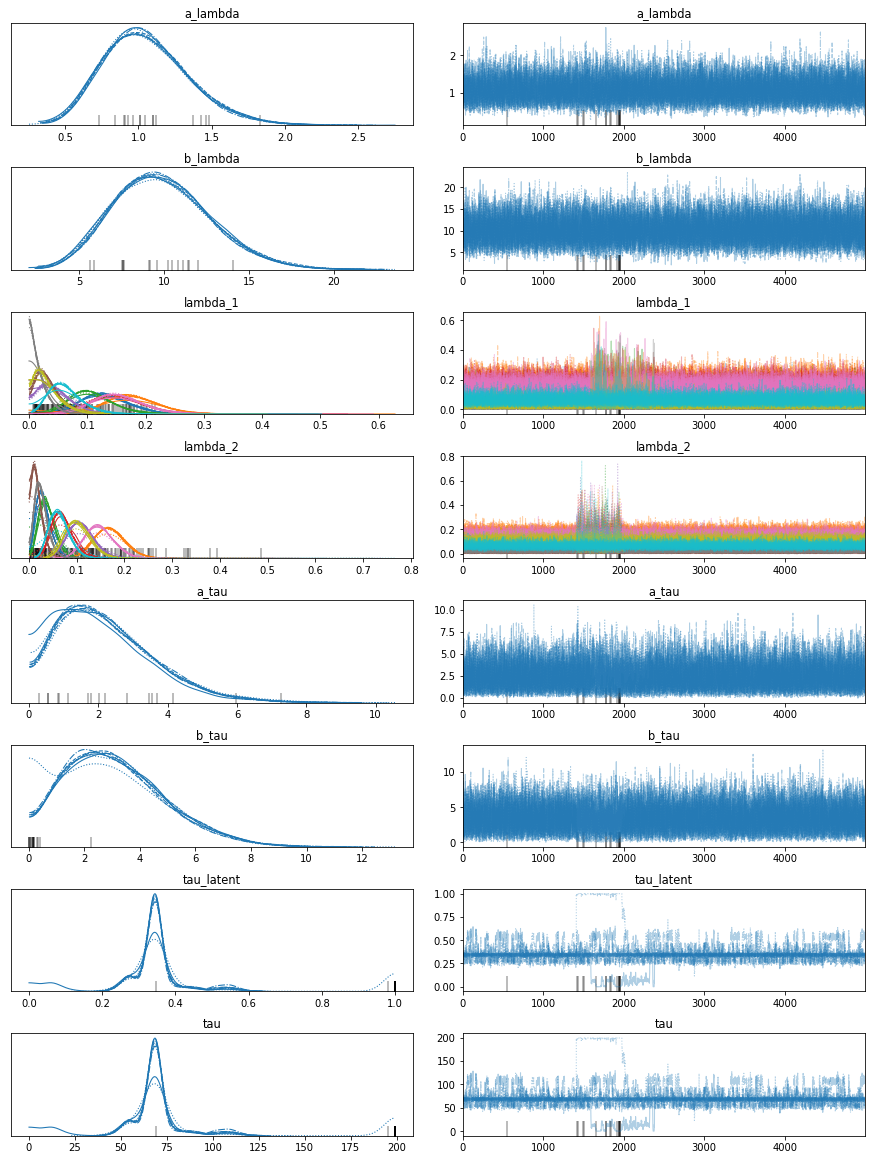

In [224]:
pm.traceplot(trace);

In [225]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a_lambda,1.06,0.29,0.55,1.61,0.00,0.00,19932.0,19932.0,18771.0,20137.0,1.00
b_lambda,9.90,2.84,4.72,15.23,0.02,0.01,24429.0,24429.0,23427.0,22475.0,1.00
lambda_1[0],0.13,0.04,0.06,0.21,0.00,0.00,1125.0,1125.0,872.0,276.0,1.01
lambda_1[1],0.18,0.05,0.09,0.26,0.00,0.00,371.0,371.0,604.0,142.0,1.01
lambda_1[2],0.11,0.04,0.04,0.17,0.00,0.00,2590.0,1603.0,2931.0,3029.0,1.00
lambda_1[3],0.15,0.04,0.08,0.23,0.00,0.00,3457.0,3457.0,2558.0,1324.0,1.00
lambda_1[4],0.04,0.03,0.00,0.09,0.00,0.00,2028.0,1998.0,2718.0,6112.0,1.00
lambda_1[5],0.03,0.02,0.00,0.07,0.00,0.00,3051.0,990.0,14792.0,5960.0,1.00
lambda_1[6],0.15,0.04,0.08,0.23,0.00,0.00,28851.0,12367.0,30502.0,8479.0,1.00
lambda_1[7],0.02,0.02,0.00,0.05,0.00,0.00,340.0,340.0,1725.0,617.0,1.01


In [226]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
#lambda_3_samples = trace['lambda_3']
#lambda_4_samples = trace['lambda_4']
lambda_stack = np.stack([lambda_1_samples,
                            lambda_2_samples])#,
                            #lambda_3_samples])#,
                            #lambda_4_samples])
#tau_1_samples = trace['tau_1']
#tau_2_samples = trace['tau_2']
#tau_samples = np.stack([tau_1_samples, tau_2_samples])
tau_samples = trace['tau']
print(tau_samples.shape)
print(lambda_stack.shape)

(40000,)
(2, 40000, 10)


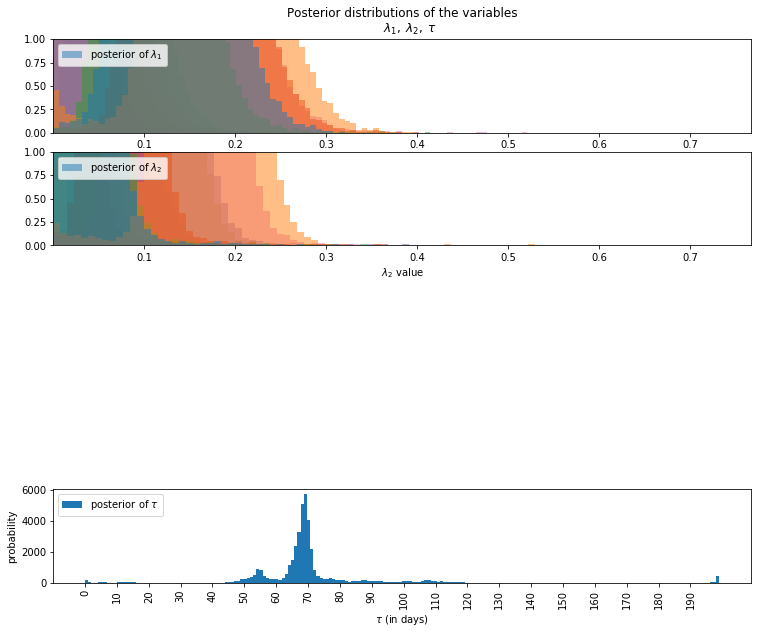

In [227]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(511)
ax.set_autoscaley_on(False)

x_lims = [min(lambda_stack.flatten()),max(lambda_stack.flatten())]
bin_num = 100

plt.hist(lambda_1_samples, histtype='stepfilled', bins=bin_num, alpha=0.5,
         label="posterior of $\lambda_1$", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlabel("$\lambda_1$ value")
plt.xlim(x_lims)

ax = plt.subplot(512)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=bin_num, alpha=0.5,
         label="posterior of $\lambda_2$", density=True)
plt.legend(loc="upper left")
plt.xlabel("$\lambda_2$ value")
plt.xlim(x_lims)

#ax = plt.subplot(513)
#ax.set_autoscaley_on(False)
#plt.hist(lambda_3_samples, histtype='stepfilled', bins=bin_num, alpha=0.5,
#         label="posterior of $\lambda_2$", density=True)
#plt.legend(loc="upper left")
#plt.xlabel("$\lambda_2$ value")
#plt.xlim(x_lims)

#ax = plt.subplot(514)
#ax.set_autoscaley_on(False)
#plt.hist(lambda_4_samples, histtype='stepfilled', bins=bin_num, alpha=0.5,
#         label="posterior of $\lambda_2$", density=True)
#plt.legend(loc="upper left")
#plt.xlabel("$\lambda_2$ value")
#plt.xlim(x_lims)

plt.subplot(515)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
        rwidth=2.)
plt.xticks(np.arange(n_count_data,step=10))



plt.legend(loc="upper left")
plt.xlabel(r"$\tau$ (in days)")
plt.xticks(rotation='vertical')
plt.ylabel("probability");

In [228]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)
ppc['obs'].shape

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 2000/2000 [00:03<00:00, 511.46it/s]


(2000, 10, 200)

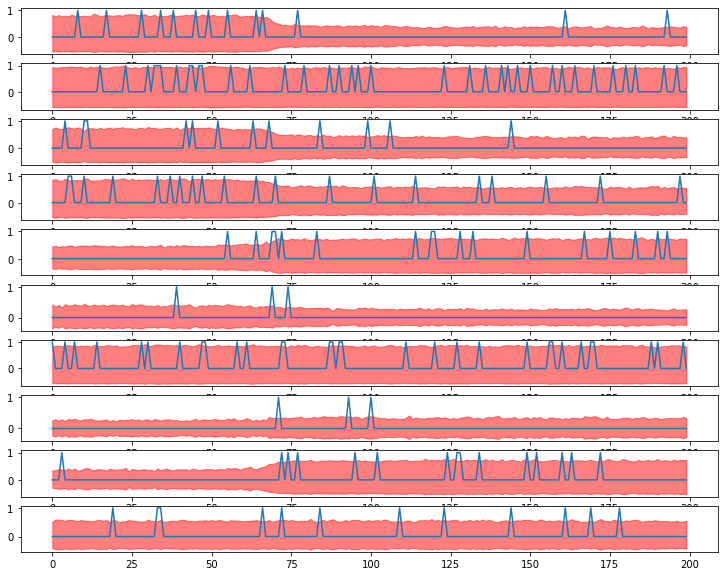

In [229]:
mean_ppc = np.mean(ppc['obs'],axis=0)
std_ppc = np.std(ppc['obs'],axis=0)

x = np.arange(count_data.shape[-1])
fig, ax = plt.subplots(count_data.shape[0],1, sharey = False)
for num,(nrn,this_ax) in enumerate(zip(count_data, ax.flatten())):
    this_ax.plot(x,nrn);
    this_ax.fill_between( x = x,
                        y1 = mean_ppc[num] + 2*std_ppc[num],
                        y2 = mean_ppc[num] - 2*std_ppc[num],
                        color = 'red', alpha = 0.5);
#plt.plot(np.mean(ppc['obs'],axis=0));
#traces = 100
#plt.plot(ppc['obs'][:100].T, alpha = 0.05);

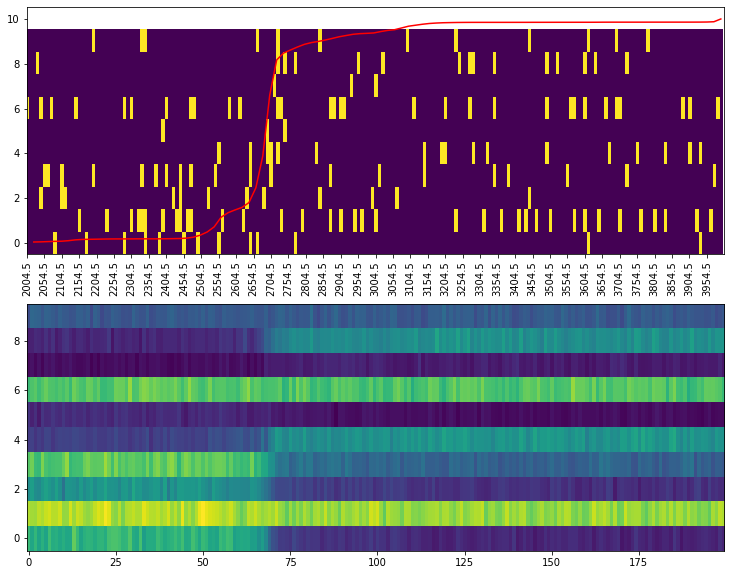

In [230]:
# Overlay raster with CDF of switchpoints
ax = plt.subplot(211)
plt.imshow(count_data,interpolation='nearest',aspect='auto',origin='lower')
tick_interval = 5
fin_prob,this_x = np.histogram(tau_samples.flatten(),100)
cum_prob = np.cumsum(fin_prob)
plt.plot(this_x[1:],cum_prob/np.max(cum_prob)*count_data.shape[0], c = 'red');
plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
plt.xlim(0,len(binned_t_vec))

ax = plt.subplot(212)
plt.imshow(mean_ppc, aspect='auto',origin='lower')